In [18]:
import pandas as pd
import numpy as np
import stat
import json
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

In [2]:
player_info = pd.read_csv("player_info.csv")
player_info = player_info.drop(columns = ['first_name','last_name','position','status','_id'])
player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        22 non-null     int64  
 1   height     21 non-null     float64
 2   weight     17 non-null     float64
 3   player_id  22 non-null     object 
dtypes: float64(2), int64(1), object(1)
memory usage: 832.0+ bytes


In [3]:
player_info

,age,height,weight,player_id
0,36,190.0,83.4,5f014aa4b8bec1cf08f7ca0f
1,21,177.0,73.2,5f0592cc239906121f930928
2,28,189.0,82.6,5f0592e2239906121f930929
3,27,180.0,80.0,5f059326c37cc79a7d6a6ca9
4,33,173.0,75.8,5f059355c37cc79a7d6a6caa
5,19,NaN,NaN,5f059378239906121f93092e
6,21,177.0,71.5,5f059388239906121f93092f
7,34,182.0,71.0,5f05939a239906121f930930
8,19,174.0,68.0,5f0593bec37cc79a7d6a6cac
9,29,169.0,64.9,5f0593d9c37cc79a7d6a6cae


In [4]:
corr = player_info.corr()
corr.style.background_gradient(cmap='Blues')

,age,height,weight
age,1.000000,0.368363,0.601280
height,0.368363,1.000000,0.686574
weight,0.601280,0.686574,1.000000


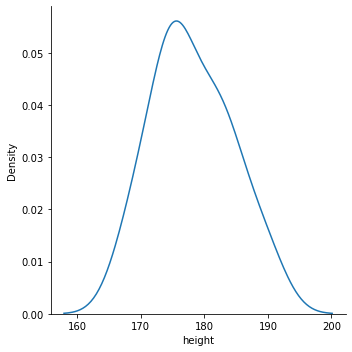

In [5]:
sns.displot(player_info, x="height", kind="kde")

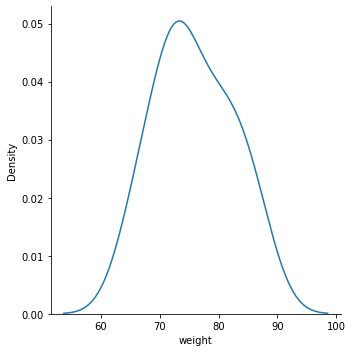

In [6]:
sns.displot(player_info, x="weight", kind="kde")

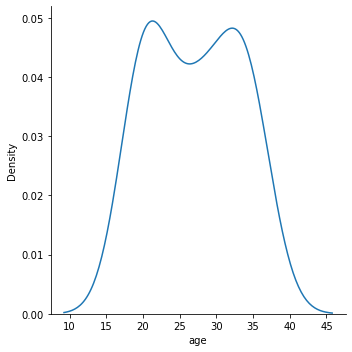

In [7]:
sns.displot(player_info, x="age", kind="kde")

In [8]:
player_info.columns.tolist()

['age', 'height', 'weight', 'player_id']

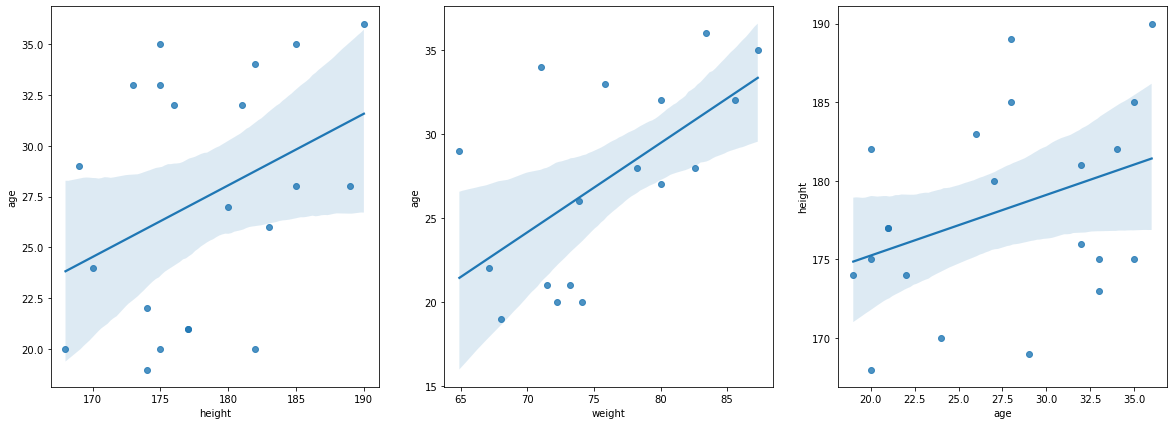

In [9]:
a = 1
b = 3
c = 1

f = plt.figure(figsize=(20,7))
for col1 in player_info.columns.tolist():
    if col1 == 'player_id':
        continue
    for col2 in player_info.columns.tolist():
        if col2 == col1 or col2 == 'player_id':
            continue
        elif c > 3:
            break
        else:
            f.add_subplot(a,b,c)
            ax = sns.regplot(x = col2, y = col1, data = player_info)
            c += 1   

# missing value imputation

In [10]:
def add_label(data, attr, name_notnan = 'Training', name_nan = 'Predict'):
    null_pos = data[attr][data[attr].isnull()].index
    data['Label'] = name_notnan
    data['Label'].iloc[null_pos] = name_nan


def mean_median_mode_imputation(data, kind = 'mean'):
    if kind == 'mean':
        return data.fillna(np.mean(data.dropna()))
    elif kind == 'median':
        return data.fillna(np.median(data.dropna()))
    elif kind == 'mode':
        return data.fillna(stat.mode(data))

In [11]:
def miss_forest_impute(data, attr):
    train_data, test_data = data[data['Label'] == 'Training'], data[data['Label'] == 'Predict']
    
    y = data[attr]
    x = data.drop(['Label', attr], axis = 1)
    
    y_train = train_data[attr]
    x_train = train_data.drop(['Label', attr], axis = 1)
    
    y_test = test_data[attr]
    x_test = test_data.drop(['Label', attr], axis = 1)
    
    
    model = RandomForestRegressor()
    model.fit(x,y)
        
    y_pred = model.predict(x_test)
    
    return y_pred, y[data['Label'] == 'Predict'].index

In [12]:
data = player_info[['age','height','weight']]
not_null_attr = data.isnull().sum()[data.isnull().sum()==0].index
null_attr = data.isnull().sum()[data.isnull().sum() != 0].index
attrbs = {}
njobs = 10

for i in null_attr:
    df = pd.concat((data[not_null_attr], data[i]), axis = 1)
    add_label(df, i)
    df[i] = mean_median_mode_imputation(df[i], kind = 'mean')
    
    for job in range(njobs):
        value, idx = miss_forest_impute(df, i)
        df[i].iloc[idx] = value
    
    attrbs[i] = df[i]

In [13]:
imputed = pd.DataFrame.from_dict(attrbs)
player_info_1 = pd.concat((data[not_null_attr], imputed), axis = 1)
player_info = pd.concat((player_info['player_id'], player_info_1), axis = 1)

In [14]:
player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  22 non-null     object 
 1   age        22 non-null     int64  
 2   height     22 non-null     float64
 3   weight     22 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 832.0+ bytes


# combine the datasets together

In [19]:
cleaned_data = pd.read_csv('cleaned_player_inj_updated.csv')
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5302 entries, 0 to 5301
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5302 non-null   int64  
 1   acute                 5302 non-null   float64
 2   acwr                  5302 non-null   float64
 3   chronic               5302 non-null   float64
 4   condition             5302 non-null   object 
 5   duration              5302 non-null   float64
 6   load                  5302 non-null   float64
 7   rpe                   5302 non-null   float64
 8   type                  5302 non-null   object 
 9   player_id             5302 non-null   object 
 10  name                  5293 non-null   object 
 11  formatteddate         5302 non-null   object 
 12  Activity              37 non-null     object 
 13  Classification        38 non-null     object 
 14  Location              36 non-null     object 
 15  OSIICs               

In [20]:
combined_data = pd.merge(cleaned_data, player_info, how = 'left', left_on = ['player_id'], right_on = ['player_id'])
combined_data

,index,acute,acwr,chronic,condition,duration,load,rpe,type,player_id,name,formatteddate,Activity,Classification,Location,OSIICs,Onset,Past Injury,Reoccurance,Side,Surgery,FormattedInjuryDate,FormattedReturnDate,injury?,NeedActualInjuryDate,daydiff,actualInjuryDate,generalizedType,log_daydiff,age,height,weight
0,2837,375.000000,1.000000,375.000000,Artificial (Dry),75.0,375.0,5.0,Practice (Field),60f254d8a1b3ec106cc401da,Khan Jahangir,2021-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,22,174.0,67.1
1,2852,438.750000,1.117589,392.586207,Grass (Wet),90.0,630.0,7.0,Practice (Field),60f254d8a1b3ec106cc401da,Khan Jahangir,2021-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,22,174.0,67.1
2,2872,410.312500,1.057711,387.925089,Artificial (Dry),65.0,325.0,5.0,Practice (Field),60f254d8a1b3ec106cc401da,Khan Jahangir,2021-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,22,174.0,67.1
3,2886,397.734375,1.030402,385.999221,Artificial (Dry),60.0,360.0,6.0,Practice (Field),60f254d8a1b3ec106cc401da,Khan Jahangir,2021-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,22,174.0,67.1
4,2902,368.300781,0.972568,378.688930,Artificial (Dry),70.0,280.0,4.0,Practice (Field),60f254d8a1b3ec106cc401da,Khan Jahangir,2021-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,22,174.0,67.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,5232,372.776023,1.314260,283.639503,Sand,75.0,600.0,8.0,Practice (Beach),60f254fb854df5b9da1bac56,LucianoDa Silva,2022-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Game,NaN,35,185.0,87.3
5298,5247,392.082017,1.328584,295.112641,Track,50.0,450.0,9.0,Quarantine - Run,60f254fb854df5b9da1bac56,LucianoDa Silva,2022-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,35,185.0,87.3
5299,5268,414.061513,1.344952,307.863493,Sand,60.0,480.0,8.0,Practice (Beach),60f254fb854df5b9da1bac56,LucianoDa Silva,2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Game,NaN,35,185.0,87.3
5300,5277,270.932201,0.985168,275.011158,Sand,55.0,385.0,7.0,Practice (Beach),60f254fb854df5b9da1bac56,LucianoDa Silva,2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Game,NaN,35,185.0,87.3


In [21]:
combined_data.to_csv('combined_data_updated.csv', header=True, index=False, encoding = 'utf-8')